## Goal

This module will dive into Streaming, and building on memory.

### Learning Steps:
- `Streaming`

#### Standard imports

In [1]:
from typing import TypedDict, Annotated, Literal

from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

from langgraph.graph import START, END, StateGraph, add_messages, MessagesState, MessageGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display, Image

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(
    model="/gpfs/projects/bsc02/llm_models/huggingface_models/Qwen3-32B",
    openai_api_key="dummy",  # vLLM doesn't need a real key
    openai_api_base="http://localhost:8002/v1",  # Your forwarded port
    temperature=0.7,
    max_tokens=500
)

In [5]:
'''
MessageState by default give messages as a key and adds "add_messages" automatically and includes TypedDict
So, its a dictionary of list
e.g.
messages: list[AnyMessages]
summary: str
'''
class State(MessagesState):
    summary: str

In [6]:
def call_model(state: State):
    summary = state.get("summary","")

    if summary:
        system_message =  f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

In [9]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]] ## its a list
    return {"summary": response.content, "messages": delete_messages}

In [10]:
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

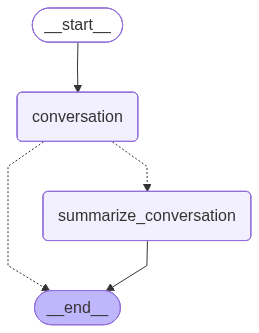

In [11]:
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

================================== Ai Message ==================================

<think>
Okay, the user just said, "hi! I'm Lance," and I need to respond. First, I should acknowledge their greeting and introduction. Since the user introduced themselves as Lance, I should address them by name to make the interaction more personal and friendly. I should also offer assistance to show that I'm here to help. Let me check if there's any specific context or previous conversation history that might influence the response, but since this is the start of the conversation, there's nothing to consider. Keep the tone positive and welcoming. Make sure to use proper punctuation and a friendly emoji to add a warm touch. Avoid any markdown and keep it natural. Alright, let's put that together.
</think>

Hi Lance! 👋 Nice to meet you! How can I assist you today? Feel free to ask me anything—I'm here to help! 😊
================================== Ai Message ==================================

<think>
Okay

In [13]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

================================== Ai Message ==================================

<think>
Okay, the user mentioned liking Nick Bosa and asked if he's the highest-paid defensive player. Let me start by confirming that Nick Bosa is indeed a standout player for the 49ers. First, I need to verify if he's currently the highest-paid defensive player. I remember that in recent years, there have been some big contracts on defense. For example, Justin Tucker from the Ravens had a massive deal, but he's a kicker. Among defensive players, players like Christian Wilkins or others might have high contracts.

Wait, I should check the latest contracts. Nick Bosa signed a 4-year, $150 million deal with the 49ers in 2022. That's a lot, but I need to see if that's the highest for a defensive player. Christian Wilkins from the Dolphins has a 5-year, $135 million contract, and there's also Myles Garrett's contract, which was around $137 million. So Bosa's contract is among the top but maybe not the absolu

In [14]:
graph.get_state(config).values.get("summary","")

'<think>\nOkay, the user wants a summary of the conversation above. Let me look back at the history.\n\nFirst, Lance introduced himself, and I welcomed him. Then he asked his name again, so I confirmed it. He mentioned liking the 49ers, and I asked about his favorite part. Now he wants a summary.\n\nI need to make sure the summary includes all key points: the introduction, the name confirmation, the 49ers fandom, and the follow-up question. Keep it concise but cover each interaction step. Also, maintain a friendly tone. Let me structure it in a few sentences, highlighting the main elements of the conversation.\n</think>\n\nHere\'s a summary of the conversation:  \n\nLance introduced himself, and the assistant warmly welcomed him. When Lance later asked, "what\'s my name?" the assistant confirmed it was him, referencing his earlier introduction. Lance then shared his enthusiasm for the San Francisco 49ers, prompting the assistant to ask about his favorite aspects of being a fan (e.g., p

## Streaming
- `graph.stream()` yields partial state updates as a generator.
- `stream_mode="updates"`: LangGraph yields incremental state updates — i.e., only the parts of the graph state that have changed since the previous chunk.
-  `stream_mode="values"`: LangGraph yields the entire state value after each node completes, not just the updates.

In [15]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': [AIMessage(content='<think>\nOkay, the user just said, "hi! I\'m Lance." Let me check the conversation history. \n\nEarlier, the user mentioned being a 49ers fan and talked about Nick Bosa. They also asked about being the highest-paid defensive player. Now, they reintroduced themselves. \n\nHmm, maybe they want to confirm their name again or just said hi again. Since the previous interaction was about the 49ers and Nick Bosa, perhaps they\'re looking to continue that conversation or maybe just testing the waters.\n\nI should acknowledge their greeting, confirm their name again, and maybe invite them to ask more questions or talk about the 49ers again. Keep it friendly and open-ended to encourage further interaction. Also, make sure to maintain the previous context about Nick Bosa in case they want to go back to that topic.\n</think>\n\nHey again, Lance! 😊 Nice to see you—ready to dive deeper into 49ers talk or discuss more about Nick Bosa? Or maybe you’ve 

In [16]:
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, 
    config, 
    stream_mode="updates"
):
    for m in chunk['conversation']["messages"]:
        m.pretty_print()

================================== Ai Message ==================================

<think>
Okay, let me see. The user just said "hi! I'm Lance" again. They've already introduced themselves before, and I responded with a friendly greeting. Now, they're repeating it. Maybe they want to make sure their name is remembered or just feeling chatty.

Looking back at the conversation history, Lance mentioned being a 49ers fan and asked about Nick Bosa's contract. I provided details about Bosa's salary and contract. Then, Lance introduced himself again, and I welcomed him with a cheerful message. Now, they're saying "hi! I'm Lance" once more.

Hmm, perhaps they're testing if the conversation is active or just being playful. Since the previous response was positive and engaging, I should maintain that tone. I need to acknowledge their message again but keep it light. Maybe add an emoji to keep it friendly. Also, offer to help with any specific topics they're interested in, like the 49ers or Nick B

#### `astream_events()`

Normally, `graph.invoke()` or `graph.stream()` only give you final states (like “messages,” “summary,” etc.) or partial state updates between nodes.

But under the hood, there’s much more happening:
- Each node in your LangGraph may invoke an LLM call,
- The LLM call itself streams tokens as they’re generated,
- LangGraph tracks internal node start/end events, message updates, and errors.

👉 `graph.astream_events()` lets you tap into that entire event stream, so you can observe what’s happening inside the graph, in real time, token by token or node by node.

| Use Case                      | Benefit                                                                         |
| ----------------------------- | ------------------------------------------------------------------------------- |
| **Real-time token streaming** | You can print each token as the LLM generates it (like OpenAI’s streaming API). |
| **Tracing / Debugging**       | You can see when each node starts and ends, and what data it emits.             |
| **Building interactive UIs**  | Perfect for updating chat bubbles, progress indicators, or dashboards live.     |
| **Profiling**                 | You can measure latency between node starts/ends.                               |


| Event Type             | Description                              | Common Use                                  |
| ---------------------- | ---------------------------------------- | ------------------------------------------- |
| `on_chat_model_start`  | When a Chat Model node (LLM call) begins | Start timing, allocate log record           |
| `on_chat_model_stream` | When partial tokens are streamed back    | Real-time token streaming (✅ the juicy one) |
| `on_chat_model_end`    | When the LLM finishes                    | Close stream, compute latency               |
| `on_tool_start`        | When a tool/function node begins         | Debug tool call latency                     |
| `on_tool_end`          | When tool execution completes            | Get result, log                             |
| `on_node_end`          | When a graph node finishes               | Update UI or save intermediate state        |
| `on_graph_end`         | When the entire graph finishes           | Final output ready                          |


In [17]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events(
    {"messages": [input_message]}, 
    config, 
    version="v2"
):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chain_start. Name: should_continue
Node: conversation. Type: on_chain_end. Name: should_continue
Node: conversation. Type: on_chain_stream. Name: conversation
Node: conversation. Type: on_chain_end. Name: conversation
Node: . Type: on_chain_stream. Name: LangGraph
Node: summarize_conversation. Type: on_chain_start. Name: summarize_conversation
Node: summarize_conversation. Type: on_chain_stream. Name: summarize_conversation
Node: summarize_conversation. Type: on_chain_end. Name: summarize_conversation
Node: . Type: on_chain_stream. Name: LangGraph
Node: . Type: on_chain_end. Name: LangGraph


In [18]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

In [35]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| NFL| team| located| in| the| San| Francisco| Bay| Area|.| They| were| founded| in| |194|6| and| joined| the| NFL| in| |194|9| following| the| merger| with| the| All|-Amer|ica| Football| Conference|.| The| team| plays| its| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|.

|The| |49|ers| are| renowned| for| their| success| during| the| |198|0|s| and| |199|0|s|,| securing| five| Super| Bowl| championships| in| the| |198|1|,| |198|4|,| |198|8|,| |198|9|,| and| |199|4| seasons|.| This| era| featured| legendary| figures| like| Joe| Montana|,| Jerry| Rice|,| and| Steve| Young|,| all| of| whom| have| left| a| lasting| legacy| on| the| team| and| the| sport|.

|Bill| Walsh|,| the| team's| head| coach| during| much| of| its| successful| period|,| introduced| the| West| Coast| offense|,| a| strategic| approach| that| revolution|ized| the| game|.| The| franchise|'s| stor|ied| history|,| passionate| "|N|iner| Empire|"| fan| ba